In [3]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print('tensorflow version', tf.__version__)
bank_data = pd.read_csv('data/1_american_dataset.csv')
# data_features = pd.read_csv('data/bankrupt_features.csv')
# data_status = pd.read_csv('data/status_bankrupt.csv')

tensorflow version 2.11.0


In [136]:
from sklearn.model_selection import train_test_split

numerical_only = bank_data.select_dtypes(include=['float64','int64'])
X = numerical_only.drop(['cik', 'fyear', 'status'], axis=1)
y = numerical_only["status"]

# split data into training (60%), validation (20%), and testing (20%) sets 
X_, X_test, y_, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)
X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)

In [137]:
print('Number of training examples: ', len(X_train))
print('Number of validation examples: ', len(X_validate))
print('Number of testing examples: ', len(X_test))

Number of training examples:  47208
Number of validation examples:  15737
Number of testing examples:  15737


In [138]:
min_val = X.min().min()
max_val = X.max().max()

# total range of dataset
print(min_val)
print(max_val)


-102362.0
1073390.5396


In [142]:
input_shape = (X.shape[1],)
input_shapeY = (y.shape[0],)
print(input_shape)
print(input_shapeY)

(18,)
(78682,)


In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import regularizers
# from tensorflow.keras.callbacks import EarlyStopping

# def create_model(input_shape):
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_shape=input_shape),
#         layers.Dropout(0.5),
#         layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# model = create_model(input_shape=(X_train.shape[1],))
# history = model.fit(X_train, y_train, validation_data=(X_val, y

In [194]:
def bankruptcy_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(18, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(9, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
    return model

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ModelCheckpoint(filepath='./best_model.h5', monitor='val_loss', save_best_only=True)
]

In [195]:
model = bankruptcy_model()
history = model.fit(X_train, y_train,
                    validation_data=(X_validate, y_validate),
                    epochs=25,
                    batch_size=18,
                    callbacks=callbacks)

Epoch 1/25
2623/2623 [==============================] - 3s 1ms/step - loss: 104.5566 - accuracy: 0.8337 - val_loss: 1.6186 - val_accuracy: 0.9327
Epoch 2/25
2623/2623 [==============================] - 3s 1ms/step - loss: 2.4501 - accuracy: 0.9211 - val_loss: 0.7843 - val_accuracy: 0.9327
Epoch 3/25
2623/2623 [==============================] - 3s 1ms/step - loss: 0.5445 - accuracy: 0.9312 - val_loss: 0.2506 - val_accuracy: 0.9327
Epoch 4/25
2623/2623 [==============================] - 3s 994us/step - loss: 0.2822 - accuracy: 0.9340 - val_loss: 0.2469 - val_accuracy: 0.9327
Epoch 5/25
2623/2623 [==============================] - 3s 981us/step - loss: 0.2580 - accuracy: 0.9341 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 6/25
2623/2623 [==============================] - 3s 992us/step - loss: 0.2478 - accuracy: 0.9344 - val_loss: 0.2466 - val_accuracy: 0.9327
Epoch 7/25
2623/2623 [==============================] - 3s 1ms/step - loss: 0.2459 - accuracy: 0.9345 - val_loss: 0.2466 - val_a

In [196]:
model.evaluate(X_test, y_test, verbose=2)

492/492 - 0s - loss: 0.2484 - accuracy: 0.9321 - 296ms/epoch - 602us/step


[0.24841910600662231, 0.9321344494819641]

In [197]:
model.predict(X_test)

492/492 [==============================] - 0s 540us/step


array([[0.06467962],
       [0.06467962],
       [0.06467962],
       ...,
       [0.06467962],
       [0.06467962],
       [0.06467962]], dtype=float32)

In [198]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

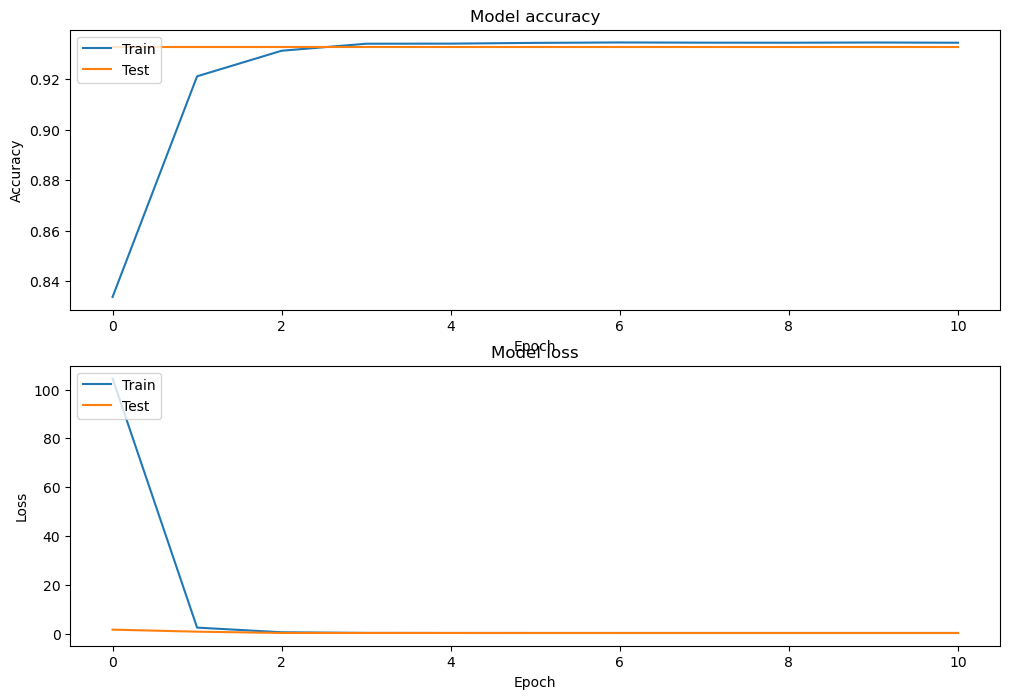

In [199]:
plot_history(history)

Text(0.5, 1.0, 'Correlation Matrix')

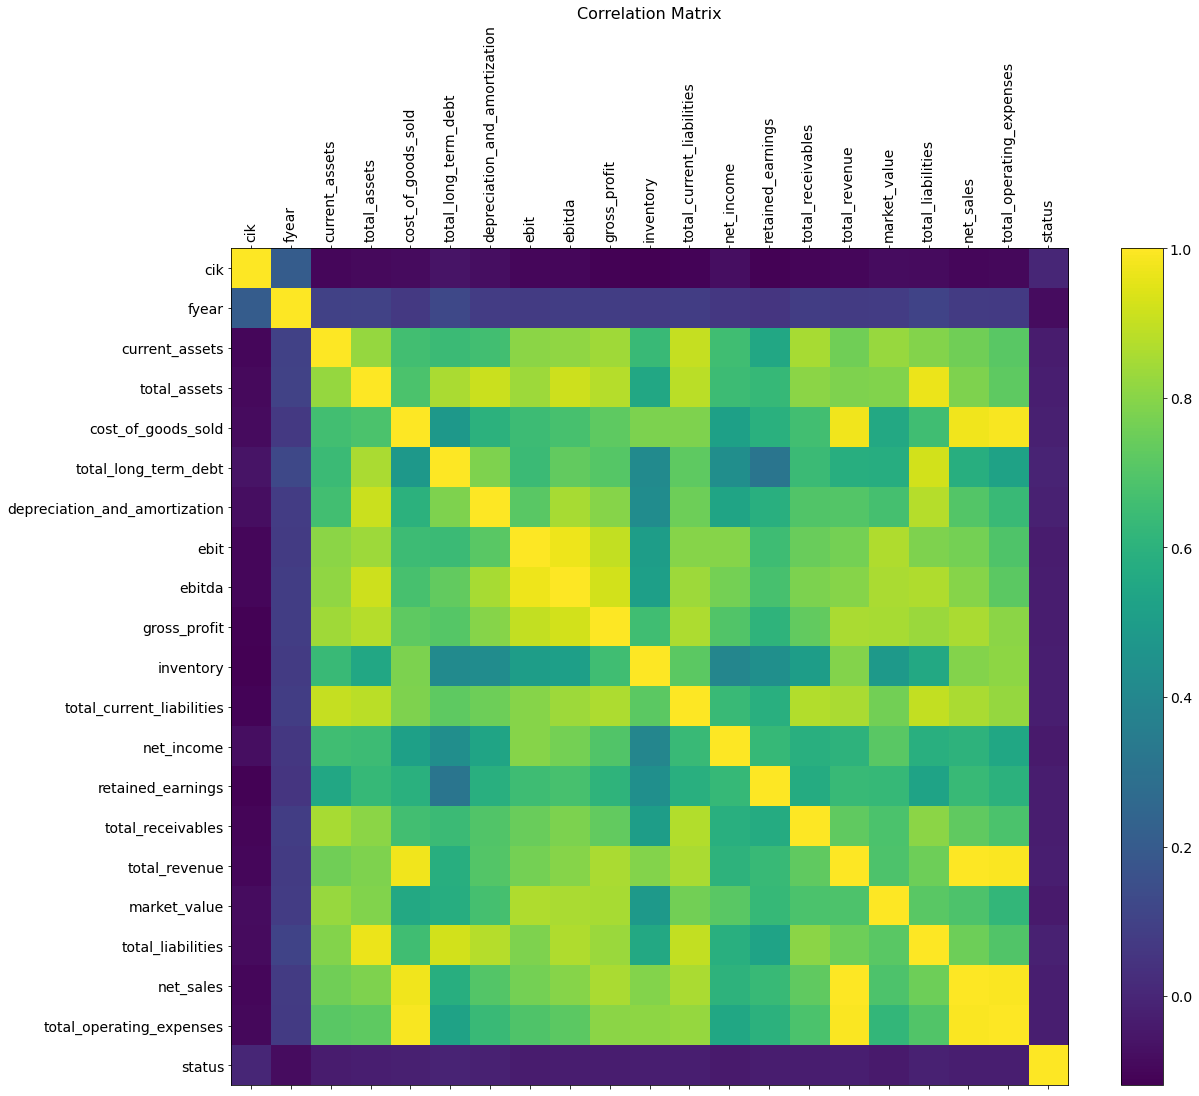

In [20]:
# Correlation Matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(bank_data.corr(), fignum=f.number)

# only select numerical values
plt.xticks(range(bank_data.select_dtypes(['number']).shape[1]), bank_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(bank_data.select_dtypes(['number']).shape[1]), bank_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [21]:
# FIXME: Creare threshold (?) for predictions to make the only possible values 0 or 1
# Probably a better way to do this
predictions

array([[7.9327002e-02],
       [5.5738468e-02],
       [6.9394588e-02],
       ...,
       [4.8700053e-02],
       [1.3328383e-04],
       [9.4740182e-01]], dtype=float32)

In [15]:
# Confusion Matrix
# FIXME: Not workign yet due to predictions not beign 0 or 1

import seaborn as sns 
# Model improvement and Evaluation 
from sklearn import metrics 
# error solution - predictions to be converted to binary since the dataset is in binary and prediction should be binary as well.
from sklearn.metrics import confusion_matrix
threshold = 0.5
binary_predictions = [1 if p > threshold else 0 for p in predictions]

cm = pd.DataFrame(metrics.confusion_matrix(y_test, predictions))
print(cm)


ValueError: Classification metrics can't handle a mix of binary and continuous targets